# Polkadot Price Prediction Using **sklearn**

In this project I'll be working with csv taken from [subscan](https://polkadot.subscan.io/tools/charts). I use 8 files, listed below with a brief description:

**Daily Active Account & Newly Created Account.csv**:  the daily active accounts and new accounts created.

**Daily Bond Value (DOT).csv**: daily amount (in dot) bonded for staking.

**Daily Fees Used.csv**: daily amount of fees (in dot) spent on the network.

**Daily Transaction Amount.csv**: amount transacted on the network.

**Daily Unbonding Schedule (DOT).csv**: dot scheduled to be released from staking.

**DOT Price (USD).csv**: the price in USD of 1 dot.

**Treasury Available Income.csv**: available income of treasury (in dot).

**Treasury Expenses.csv**: expenses per day of treasury.


## import packages and csv files

In [22]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

In [2]:
active_inactive = pd.read_csv("data/Daily Active Account & Newly Created Account.csv", parse_dates=['Date'])
bond = pd.read_csv("data/Daily Bond Value (DOT).csv", parse_dates=['Date'])
fees = pd.read_csv("data/Daily Fees Used.csv", parse_dates=['Date'])
transactions = pd.read_csv("data/Daily Transaction Amount.csv", parse_dates=['Date'])
unbonding = pd.read_csv("data/Daily Unbonding Schedule (DOT).csv", parse_dates=['Date'])
price = pd.read_csv("data/DOT Price (USD).csv", parse_dates=['Date'])
treasury_available = pd.read_csv('data/Treasury Available Income.csv', parse_dates=['Date'])
treasury_expense = pd.read_csv('data/Treasury Expenses.csv', parse_dates=['Date'])

## rename columns

In [3]:
active_inactive = active_inactive.rename(columns={'Active Account': 'Active_account', 'New Account': 'New_account'})
bond = bond.rename(columns={'Value':'Bond_value'})
fees = fees.rename(columns={'DOT':'DOT_fees'})
transactions = transactions.rename(columns={'DOT':'DOT_transactions'})
unbonding = unbonding.rename(columns={'Value':'Unbonding_value'})
price = price.rename(columns={' Price (USD)': 'Price_USD'})
treasury_available = treasury_available.rename(columns={'Value': 'available_value'})
treasury_expense = treasury_expense.rename(columns={'Value': 'expense_value'})

## merge DataFrames, clean, create target

In [4]:
df = [price, transactions, fees, bond, unbonding, active_inactive, treasury_available, treasury_expense]
df_merged = reduce(lambda left, right: pd.merge(left, right, on=['Date'], how='outer'), df)

In [5]:
df_merged['Seven_day_price'] = df_merged['Price_USD'].shift(-7)
df_merged = df_merged.dropna()

In [6]:
display(df_merged.head())
display(df_merged.tail())

,Date,Price_USD,DOT_transactions,DOT_fees,Bond_value,Unbonding_value,Active_account,New_account,available_value,expense_value,Seven_day_price
1,2020-07-18,1.750289,600.0,4.2493,3.225823e+05,49257.838569,197.0,30.0,0.0,0.0,1.709566
2,2020-07-19,1.605382,666.0,9.9014,2.009450e+07,274420.000000,395.0,21.0,0.0,0.0,1.678297
3,2020-07-20,1.571536,7000.0,5.8391,2.922391e+07,18027.400000,286.0,30.0,0.0,0.0,1.702217
4,2020-07-21,1.588110,0.0,4.5909,1.489727e+05,25100.000000,173.0,18.0,0.0,0.0,1.770439
5,2020-07-22,1.570872,0.0,3.7842,2.527056e+06,800000.000000,169.0,11.0,0.0,0.0,1.771341


,Date,Price_USD,DOT_transactions,DOT_fees,Bond_value,Unbonding_value,Active_account,New_account,available_value,expense_value,Seven_day_price
634,2022-04-12,17.941162,8.573963e+06,165.978411,1.241070e+07,2.034294e+04,1917.0,2108.0,2.804684e+07,0.0,18.999490
635,2022-04-13,18.063836,1.941962e+07,147.440837,1.049751e+05,1.325278e+05,1757.0,1839.0,2.812011e+07,0.0,19.100654
636,2022-04-14,18.164701,4.887517e+06,174.040428,8.649407e+05,3.778230e+06,3006.0,2066.0,2.819367e+07,0.0,18.329985
637,2022-04-15,18.428432,1.104774e+07,138.297388,5.594405e+04,4.663664e+04,1570.0,1725.0,2.826710e+07,0.0,18.660793
638,2022-04-16,18.494261,1.978290e+06,138.533526,5.663654e+04,3.605870e+05,1524.0,1872.0,2.833720e+07,0.0,18.954922


## visual exploration

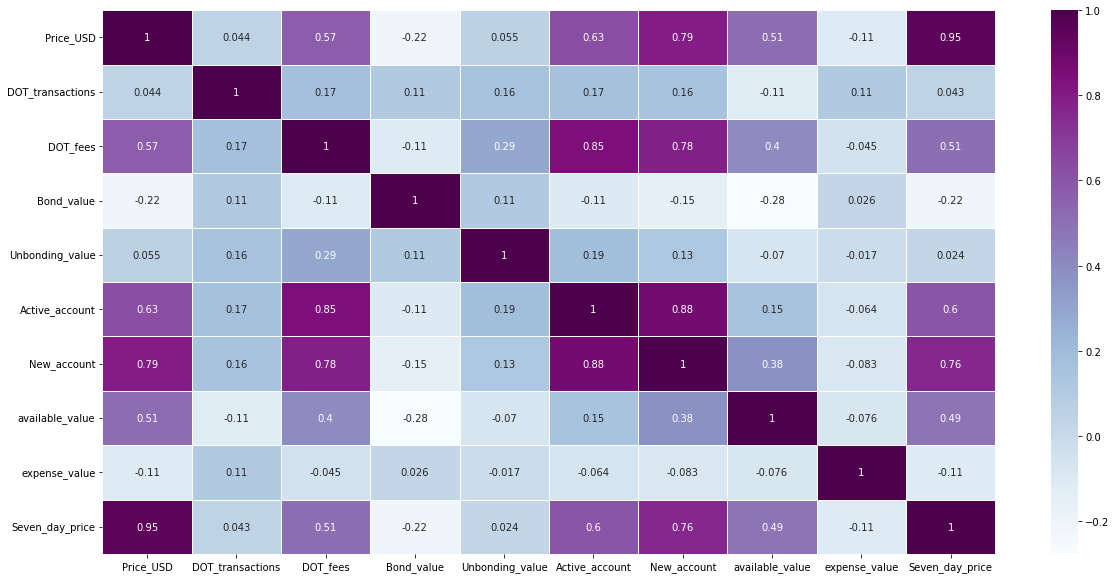

In [7]:
plt.figure(figsize=(20, 10))
sns.heatmap(df_merged.corr(), annot=True, cmap='BuPu', linewidth=1, linecolor='w');

> We can see here a (unsurprising) high correlation between the Price_USD and Seven_day_price. New_account, Active_account, DOT_fees, and available_value also have a high correlation with Seven_day_price, but we must determine whether they are correlated with each other before they can be used in the model. 

### investigate correlations between features

In [8]:
corr = df_merged.corr()

In [9]:
corr_df = corr.unstack().reset_index()
corr_df.columns = ['feature_1','feature_2', 'correlation']
corr_df.sort_values(by="correlation",ascending=False, inplace=True)
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']]
feature_correlation = corr_df[corr_df['feature_1'] == 'Seven_day_price']

In [10]:
corr_df.head()

,feature_1,feature_2,correlation
90,Seven_day_price,Price_USD,0.950528
9,Price_USD,Seven_day_price,0.950528
65,New_account,Active_account,0.876939
56,Active_account,New_account,0.876939
25,DOT_fees,Active_account,0.845768


In [11]:
feature_correlation.head()

,feature_1,feature_2,correlation
90,Seven_day_price,Price_USD,0.950528
96,Seven_day_price,New_account,0.758976
95,Seven_day_price,Active_account,0.604790
92,Seven_day_price,DOT_fees,0.506402
97,Seven_day_price,available_value,0.488297


## use permutation_importance to find most important features

### create feature matrix (X) and target vector (y)

In [12]:
X = df_merged.copy().drop(['Seven_day_price', 'Date'], axis=1)
y = df_merged['Seven_day_price']

In [13]:
type(X)

pandas.core.frame.DataFrame

In [14]:
type(y)

pandas.core.series.Series

### run feature permutation

In [15]:
regressor = LinearRegression().fit(X, y)
permutation_score = permutation_importance(regressor, X, y, n_repeats=10)
importance_df = pd.DataFrame(np.vstack((X.columns,
                                        permutation_score.importances_mean)).T)
importance_df.columns=['feature','score decrease']

importance_df = importance_df.sort_values(by="score decrease", ascending = False)

In [16]:
importance_df

,feature,score decrease
0,Price_USD,1.603529
2,DOT_fees,0.084487
5,Active_account,0.062478
7,available_value,0.009912
1,DOT_transactions,0.000416
6,New_account,0.000238
3,Bond_value,0.000122
8,expense_value,0.000052
4,Unbonding_value,-0.000012


> importance_df shows that only four features have a noticeable effect on the score of the model

In [17]:
importance_df = importance_df[importance_df['score decrease'] > 0.01]

### redefine X with only four features

In [18]:
X = df_merged.loc[:, importance_df['feature']]

### implement train_test_split to prevent data leakage

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### scale the feature data

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[ 1.1738679 , -0.12075018,  0.27991862],
       [-0.24926886, -0.16876416,  0.16625318],
       [-1.31393585, -0.61416545, -0.55865578],
       ...,
       [ 1.60741134, -0.02484181,  0.41261808],
       [ 0.55834754,  0.04342997,  0.42608554],
       [-1.29607671, -0.67566408, -0.66244507]])

In [24]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[ 1.67342823e+00, -3.28696531e-02,  3.98252775e-01],
       [ 1.10637564e+00, -3.65858555e-02,  3.56952537e-01],
       [-1.38718756e+00, -5.25789629e-01, -4.02612704e-01],
       [-3.92523994e-01,  1.83482625e-01, -5.78228497e-01],
       [-2.88483017e-01, -4.22973145e-02, -7.08414029e-01],
       [-1.34654578e+00, -6.05233296e-01, -5.25076887e-01],
       [-3.20979794e-01,  8.18796135e-03, -7.23318028e-01],
       [-1.27916586e+00, -6.66103201e-01, -6.37126227e-01],
       [ 1.04203265e+00, -1.96074355e-01,  1.20463785e-01],
       [ 5.66417791e-01,  2.36559467e-01, -5.13045948e-01],
       [ 3.85635864e-01,  4.06242000e-01, -4.42296845e-01],
       [-3.30651619e-01, -4.19188430e-02, -7.47559472e-01],
       [ 8.65372292e-01,  2.45066275e-01,  7.71391444e-01],
       [ 6.13748650e-01,  1.81820138e-01, -5.04067636e-01],
       [ 2.28170078e-01,  1.35061072e-01, -4.99219347e-01],
       [ 1.46506265e+00,  6.42611320e-01,  9.09477891e-01],
       [ 7.10754634e-01, -7.45491511e-02